In [58]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import tensorflow as tf 

import sklearn
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model


Input dimensions: 784


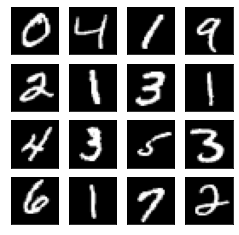

In [71]:
(x_train, _), (x_test, y_test) = mnist.load_data()
n = 4

# Normalize pixel values
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print("Input dimensions:", x_train[0].size)

plt.figure(figsize=(4, 4))

# Plot 4x4 grid of training samples
for i in range(1, n*n+1):
    ax = plt.subplot(n, n, i)
    plt.imshow(x_train[i])
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)


In [60]:
# Define autoencoder

latent_dim = 32

class Autoencoder(Model):
    # Constructor
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            # Converts tensor input to vector? (28, 28) -> (784)
            layers.Flatten(),
            layers.Dense(latent_dim, activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
            # Output 784 pixel values between [0, 1]
            layers.Dense(784, activation='sigmoid'),
            layers.Reshape((28, 28)),
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(latent_dim)

In [61]:
# "Configures the model for training", we specify loss, metrics, etc.
autoencoder.compile(optimizer='adam', loss = losses.MeanSquaredError())

In [62]:
# Training
# epochs: nr passes over the dataset
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0318 - val_loss: 0.0161
Epoch 2/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0135 - val_loss: 0.0114
Epoch 3/10
1875/1875 [==============================] - 2s 948us/step - loss: 0.0113 - val_loss: 0.0105
Epoch 4/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0108 - val_loss: 0.0103
Epoch 5/10
1875/1875 [==============================] - 2s 979us/step - loss: 0.0106 - val_loss: 0.0102
Epoch 6/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0105 - val_loss: 0.0101
Epoch 7/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0104 - val_loss: 0.0100
Epoch 8/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0103 - val_loss: 0.0100
Epoch 9/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0103 - val_loss: 0.0101
Epoch 10/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0

In [63]:
autoencoder.summary()

Model: "autoencoder_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_10 (Sequential)   (None, 32)                25120     
_________________________________________________________________
sequential_11 (Sequential)   (None, 28, 28)            25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [64]:
# Evaluate of test set
encoded_imgs = autoencoder.encoder(x_test).numpy()
print(encoded_imgs.shape)
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

(10000, 32)


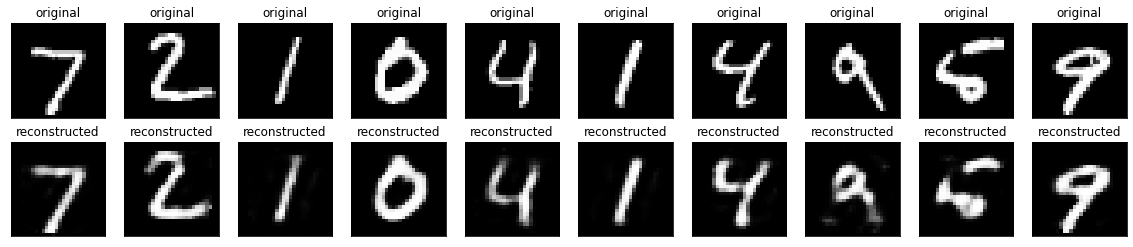

In [65]:
n = 10
plt.figure(figsize=(20, 4)) # Specifies window width / height
for i in range(n):
    # original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("original")
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [66]:
# linear interpolation test
img_1 = x_test[2].reshape(1, x_test[0].size) # resize to single element tensor
img_2 = x_test[3].reshape(1, x_test[1].size)

# image encodings
encoded_img_1 = autoencoder.encoder(img_1).numpy() 
encoded_img_2 = autoencoder.encoder(img_2).numpy()
nbr_points = 12

t = np.linspace(1, 0, num=nbr_points)

encoded_interpols = np.zeros([nbr_points, encoded_img_1.size])

for i in range(nbr_points):
    encoded_interpols[i] = t[i] * encoded_img_1 + (1-t[i]) * encoded_img_2

print(encoded_interpols.shape)

decoded_interpols = autoencoder.decoder(encoded_interpols).numpy()

(12, 32)


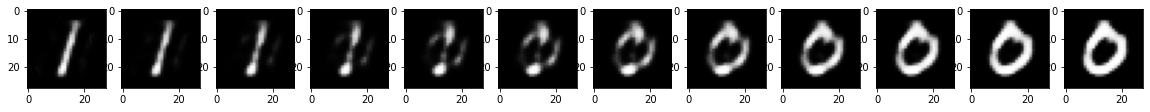

In [67]:
# Plot interpolations

plt.figure(figsize=(20, 4))
for i in range(nbr_points):
    ax = plt.subplot(1, nbr_points, i+1)
    plt.imshow(decoded_interpols[i])

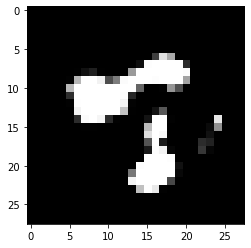

In [68]:
random_latent = np.random.rand(latent_dim)*37
random_latent = random_latent.reshape(1, latent_dim)
random_decoded = autoencoder.decoder(random_latent)

plt.figure()
plt.imshow(random_decoded.numpy()[0])


In [91]:
# T-SNE test

from sklearn.manifold import TSNE

embeddings_tsne = TSNE(n_components=2).fit_transform(encoded_imgs)
interpols_tsne = TSNE(n_components=2).fit_transform(encoded_interpols)

print(embeddings_tsne.shape)

(10000, 2)


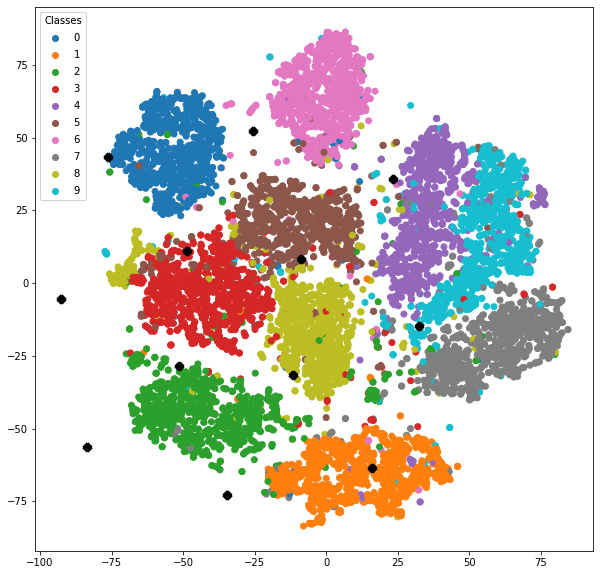

In [98]:
# Plot projected embeddings
fig, ax = plt.subplots(figsize=(10,10))

scatter = ax.scatter(embeddings_tsne[:,0], embeddings_tsne[:,1], c = y_test.astype('float32'), cmap='tab10')

# Plot interpolated points, weird structure caused by TSNE?
ax.scatter(interpols_tsne[:,0], interpols_tsne[:,1], marker="x", color='000000', linewidths=6)

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="Classes")

ax.add_artist(legend1)



plt.show()

In [90]:
encoded_interpols

array([[ 4.28143787,  1.85502958,  7.02951574,  6.58939123,  4.54124069,
         0.47260052,  2.05768108,  6.78052902,  0.26042652,  2.45711589,
         1.96039975,  0.92033219,  5.92164183,  6.64359808,  2.70624423,
         3.30121231,  7.82330656,  5.4774332 ,  5.18268156,  0.96873301,
         1.97518957,  4.20604992,  4.48338604,  6.77713537,  1.06213737,
         5.74106121,  7.4029398 ,  4.92369843,  1.89807904,  6.92856789,
         6.56238651,  3.11961031],
       [ 4.49598026,  2.79119158,  8.04257202,  6.67306566,  4.48093987,
         1.16402912,  3.00803971,  7.12075853,  1.02054441,  3.55144262,
         3.5741477 ,  2.18303823,  6.71182489,  7.21785927,  3.12656617,
         3.74727273,  7.43674469,  5.51946688,  5.43648291,  1.72410631,
         3.1099546 ,  4.71431446,  4.86417055,  7.41635513,  2.47180367,
         6.18398571,  7.40729904,  5.49033165,  2.56089449,  7.44953918,
         7.22680521,  4.00447941],
       [ 4.71052265,  3.7273531 ,  9.05562687,  6.7567